In [1]:
import numpy as np

In [2]:
def convert_polar_to_cartesian(theta: np.ndarray, phi: np.ndarray, radius: float):
    """
    Convert polar coordinates (theta, phi) to Cartesian coordinates (x, y, z).
    """
    x = radius * np.sin(phi) * np.cos(theta)
    y = radius * np.sin(phi) * np.sin(theta)
    z = radius * np.cos(phi)
    return np.array([x, y, z]).T

In [3]:
def generate_satellite_positions(num_satellites, radius):
    """
    Generate random positions over polar coordinates for a given number of satellites.
    Convert polar coordinates to Cartesian coordinates.
    Ouput shape: (num_satellites, 3)
    """
    theta = np.random.uniform(0, 2 * np.pi, num_satellites)
    phi = np.random.uniform(0, np.pi / 2, num_satellites)  # Only consider the Northern hemisphere
    return convert_polar_to_cartesian(theta, phi, radius)


In [4]:
np.random.seed(42)

sats = generate_satellite_positions(1000, 7000)
sats.shape

(1000, 3)

In [5]:
def choose_start_end(satellite_positions):
    """
    Choose start and end satellites for a transfer operation.
    Ensure that the angle between the two satellites is greater than 135 degrees.
    Return (start_index, end_index).
    """
    n_satellites = satellite_positions.shape[0]
    for i in range(n_satellites):
        for j in range(i + 1, satellite_positions.shape[0]):
            angle = np.arccos(
                np.dot(satellite_positions[i], satellite_positions[j])
                / (np.linalg.norm(satellite_positions[i]) * np.linalg.norm(satellite_positions[j]))
            )
            if angle > 3 * np.pi / 4:  # 135 degrees in radians
                return i, j
    err_msg = (
        "No valid start and end satellites found with angle > 135 degrees. "
        "Consider adjusting satellite positions or the number of satellites."
    )
    raise ValueError(err_msg)

In [6]:
src, dst = choose_start_end(sats)
print(f"Start: {src}, end: {dst}")

Start: 1, end: 954


In [7]:
def find_neighbours(cur_idx, dst_pos, satellite_positions):
    """
    Find all neighbours of the current satellite that satisfy the following conditions:
    - Within the communication range: The distance to the neighbour is less than D_MAX.
    - Forward path: The angles made by the neighbours satellite, the current satellite,
    and the destination satellite are acute.
    Returns N_NEIGHBOURS nearest neighbours.
    """
    # Exclude the current satellite itself
    cur_pos = satellite_positions[cur_idx]  # Get the current coordinates first
    satellite_positions = np.delete(satellite_positions, cur_idx, axis=0)

    # Calculate distances to all other satellites
    neighbour_vectors = satellite_positions - cur_pos
    distances = np.linalg.norm(neighbour_vectors, axis=1)

    # Communication range filter
    within_range = distances < 2000

    # Forward path condition
    dst_vector = dst_pos - cur_pos
    forward = np.dot(neighbour_vectors, dst_vector) > 0.5

    # Combine conditions
    neighbours = np.where(within_range & forward)[0]

    # Sort neighbours by distance to the current satellite
    sorted_indices = np.argsort(distances[neighbours])
    return neighbours[sorted_indices][:10].tolist() if len(neighbours) > 0 else []

In [8]:
dst_pos = sats[dst]

for i in range(500):
    n_neighbours = len(find_neighbours(i, dst_pos, sats))
    if n_neighbours < 10:
        print(f"Satellite {i}, {n_neighbours} neighbours")

Satellite 2, 7 neighbours
Satellite 11, 7 neighbours
Satellite 18, 6 neighbours
Satellite 22, 9 neighbours
Satellite 24, 4 neighbours
Satellite 54, 4 neighbours
Satellite 61, 9 neighbours
Satellite 74, 1 neighbours
Satellite 84, 9 neighbours
Satellite 103, 7 neighbours
Satellite 122, 9 neighbours
Satellite 153, 9 neighbours
Satellite 171, 9 neighbours
Satellite 176, 9 neighbours
Satellite 183, 8 neighbours
Satellite 196, 2 neighbours
Satellite 209, 4 neighbours
Satellite 350, 8 neighbours
Satellite 360, 7 neighbours
Satellite 375, 5 neighbours
Satellite 388, 8 neighbours
Satellite 415, 4 neighbours
Satellite 425, 8 neighbours
Satellite 452, 9 neighbours
Satellite 455, 5 neighbours
Satellite 457, 9 neighbours
Satellite 463, 9 neighbours
Satellite 464, 8 neighbours
Satellite 466, 9 neighbours


In [3]:
from typing import TypedDict, Optional

class Experience(TypedDict):
    """
    A single experience tuple (s, a, r, s').
    Fields can be None if not yet available.
    """

    state: Optional[np.ndarray]
    action: Optional[int]
    reward: Optional[float]
    next_state: Optional[np.ndarray]


class ExperienceBuffer:
    """
    Store incomplete experiences e = (s, a, r, s').
    Necessary because s' IS NOT IMMEDIATELY AVAILABLE after taking action a.
    The next time the same package is processed, we can update s' and push it out of the buffer.
    """

    def __init__(self):
        self.buffer = {}

    def add_experience(self, package_id, experience: Experience):
        """
        Add an experience to the buffer.
        """
        self.buffer[package_id] = experience

    def update_experience(self, package_id, new_experience: Experience):
        """
        Update the state of an experience in the buffer based on package_id.
        """
        if package_id in self.buffer:
            experience = self.buffer[package_id]
            for key in new_experience:
                if new_experience[key] is not None:
                    experience[key] = new_experience[key]
        else:
            raise KeyError(f"Package ID {package_id} not found in buffer.")

    def pop_experience(self, package_id):
        """
        Remove an experience from the buffer based on package_id.
        """
        if package_id in self.buffer:
            return self.buffer.pop(package_id)
        else:
            raise KeyError(f"Package ID {package_id} not found in buffer.")

In [6]:
buffer = ExperienceBuffer()
buffer.add_experience(
    package_id=0,
    experience={"action": 0}
)
buffer.update_experience(
    package_id=0,
    new_experience={"reward": -100}
)
buffer.buffer

{0: {'action': 0, 'reward': -100}}

In [1]:
from typing import List

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

df_results = pd.read_csv("data/dqn_results_20251201.csv")
df_results.head()

,AoI,Dropped_Ratio
0,1.3455,0.2048
1,1.2479,0.2229
2,1.2798,0.2892
3,1.2137,0.3253
4,1.2210,0.3855


In [8]:
from src.utils.report import calc_running_mean_adaptive

window_size = 4
aoi_mean = calc_running_mean_adaptive(df_results["AoI"], window_size)
drop_mean = calc_running_mean_adaptive(df_results["Dropped_Ratio"], window_size)

df_mean = pd.DataFrame({
    "aoi_mean": aoi_mean,
    "drop_mean": drop_mean
})

df_mean["fitness"] = df_mean.apply(
    lambda row: ((1 - row["drop_mean"])/row["aoi_mean"]) if row["drop_mean"] < 0.1 else -row["drop_mean"]/row["aoi_mean"],
    axis=1
)
df_mean.tail()

,aoi_mean,drop_mean,fitness
95,0.625650,0.088875,1.456285
96,0.632650,0.102425,-0.161898
97,0.637700,0.131025,-0.205465
98,0.643450,0.138550,-0.215324
99,0.642575,0.126500,-0.196864


In [9]:
max(df_mean["fitness"])

1.4833683190699176

In [ ]:
import cv2
import os
import glob

INPUT_DIR = "figures"
OUTPUT_DIR = "/home/lan/Desktop/figures"

for img_file in glob.glob(os.path.join(os.path.expanduser(INPUT_DIR), "*.png")):
    filename = os.path.basename(img_file)
    print(f"Resizing {filename}...")
    img = cv2.imread(img_file, cv2.IMREAD_UNCHANGED)
    h, w = img.shape[:2]
    img_resized = cv2.resize(
    img,
    (int(w * 0.5), int(h * 0.5)),
    interpolation=cv2.INTER_AREA
)
    img_resized.save(f"{OUTPUT_DIR}/{filename}")

Resizing dqn_average_aoi_over_episodes.png...
Resizing dqn_packet_drop_ratio_over_episodes.png...
Resizing average_aoi_comparison.png...
Resizing dqn_objective_function_over_episodes.png...
Resizing objective_function_comparison.png...
Resizing packet_drop_ratio_comparison.png...


# Change params

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
objective_fn = lambda row: row["average_aoi"]/(1 - row["dropped_ratio"])

### Original (queue_limit = 12, dmax = 2000)

In [5]:
df1 = pd.read_csv("eval_results/greedy_nearest_eval.csv")
df2 = pd.read_csv("eval_results/greedy_expected_time_eval.csv")
df3 = pd.read_csv("eval_results/dqn_eval.csv")
df4 = pd.read_csv("eval_results/dqn_heuristic_eval.csv")

df1["objective"] = df1.apply(objective_fn, axis=1)
df2["objective"] = df2.apply(objective_fn, axis=1)
df3["objective"] = df3.apply(objective_fn, axis=1)
df4["objective"] = df4.apply(objective_fn, axis=1)

df1.head()

,average_aoi,dropped_ratio,objective
0,0.910933,0.867470,6.873401
1,0.918127,0.891566,8.467174
2,0.787855,0.879518,6.539200
3,1.008243,0.867470,7.607651
4,0.820734,0.885542,7.170621


In [6]:
original_means = {
    "aoi_mean": {
        "greedy_nearest": df1["average_aoi"].mean(),
        "greedy_expected": df2["average_aoi"].mean(),
        "dqn": df3["average_aoi"].mean(),
        "dqn_heuristic": df4["average_aoi"].mean()
    },
    "drop_mean": {
        "greedy_nearest": df1["dropped_ratio"].mean(),
        "greedy_expected": df2["dropped_ratio"].mean(),
        "dqn": df3["dropped_ratio"].mean(),
        "dqn_heuristic": df4["dropped_ratio"].mean()
    },
}

### Queue_limit = 10

In [8]:
df1 = pd.read_csv("eval_results/queue_limit_10/greedy_nearest_eval.csv")
df2 = pd.read_csv("eval_results/queue_limit_10/greedy_expected_time_eval.csv")
df3 = pd.read_csv("eval_results/queue_limit_10/dqn_eval.csv")
df4 = pd.read_csv("eval_results/queue_limit_10/dqn_heuristic_eval.csv")

df1["objective"] = df1.apply(objective_fn, axis=1)
df2["objective"] = df2.apply(objective_fn, axis=1)
df3["objective"] = df3.apply(objective_fn, axis=1)
df4["objective"] = df4.apply(objective_fn, axis=1)

df1.head()

,average_aoi,dropped_ratio,objective
0,0.817484,0.879518,6.785119
1,0.894386,0.897590,8.733416
2,0.892468,0.909639,9.876647
3,0.974445,0.909639,10.783860
4,0.867507,0.891566,8.000340


In [9]:
queue_10_means = {
    "aoi_mean": {
        "greedy_nearest": df1["average_aoi"].mean(),
        "greedy_expected": df2["average_aoi"].mean(),
        "dqn": df3["average_aoi"].mean(),
        "dqn_heuristic": df4["average_aoi"].mean()
    },
    "drop_mean": {
        "greedy_nearest": df1["dropped_ratio"].mean(),
        "greedy_expected": df2["dropped_ratio"].mean(),
        "dqn": df3["dropped_ratio"].mean(),
        "dqn_heuristic": df4["dropped_ratio"].mean()
    },
}

### Queue_limit = 14

In [10]:
df1 = pd.read_csv("eval_results/queue_limit_14/greedy_nearest_eval.csv")
df2 = pd.read_csv("eval_results/queue_limit_14/greedy_expected_time_eval.csv")
df3 = pd.read_csv("eval_results/queue_limit_14/dqn_eval.csv")
df4 = pd.read_csv("eval_results/queue_limit_14/dqn_heuristic_eval.csv")

df1["objective"] = df1.apply(objective_fn, axis=1)
df2["objective"] = df2.apply(objective_fn, axis=1)
df3["objective"] = df3.apply(objective_fn, axis=1)
df4["objective"] = df4.apply(objective_fn, axis=1)

df1.head()

,average_aoi,dropped_ratio,objective
0,0.953092,0.855422,6.592219
1,0.918662,0.891566,8.472103
2,0.876943,0.855422,6.065522
3,1.042493,0.849398,6.922154
4,1.043474,0.879518,8.660834


In [11]:
queue_14_means = {
    "aoi_mean": {
        "greedy_nearest": df1["average_aoi"].mean(),
        "greedy_expected": df2["average_aoi"].mean(),
        "dqn": df3["average_aoi"].mean(),
        "dqn_heuristic": df4["average_aoi"].mean()
    },
    "drop_mean": {
        "greedy_nearest": df1["dropped_ratio"].mean(),
        "greedy_expected": df2["dropped_ratio"].mean(),
        "dqn": df3["dropped_ratio"].mean(),
        "dqn_heuristic": df4["dropped_ratio"].mean()
    },
}

### D_max = 1750

In [12]:
df1 = pd.read_csv("eval_results/dmax_1750/greedy_nearest_eval.csv")
df2 = pd.read_csv("eval_results/dmax_1750/greedy_expected_time_eval.csv")
df3 = pd.read_csv("eval_results/dmax_1750/dqn_eval.csv")
df4 = pd.read_csv("eval_results/dmax_1750/dqn_heuristic_eval.csv")

df1["objective"] = df1.apply(objective_fn, axis=1)
df2["objective"] = df2.apply(objective_fn, axis=1)
df3["objective"] = df3.apply(objective_fn, axis=1)
df4["objective"] = df4.apply(objective_fn, axis=1)

df1.head()

,average_aoi,dropped_ratio,objective
0,0.833134,0.867470,6.286374
1,0.921880,0.891566,8.501781
2,0.796925,0.879518,6.614474
3,0.930682,0.873494,7.356822
4,0.852794,0.885542,7.450725


In [13]:
dmax_1750_means = {
    "aoi_mean": {
        "greedy_nearest": df1["average_aoi"].mean(),
        "greedy_expected": df2["average_aoi"].mean(),
        "dqn": df3["average_aoi"].mean(),
        "dqn_heuristic": df4["average_aoi"].mean()
    },
    "drop_mean": {
        "greedy_nearest": df1["dropped_ratio"].mean(),
        "greedy_expected": df2["dropped_ratio"].mean(),
        "dqn": df3["dropped_ratio"].mean(),
        "dqn_heuristic": df4["dropped_ratio"].mean()
    },
}

### D_max = 2250

In [14]:
df1 = pd.read_csv("eval_results/dmax_2250/greedy_nearest_eval.csv")
df2 = pd.read_csv("eval_results/dmax_2250/greedy_expected_time_eval.csv")
df3 = pd.read_csv("eval_results/dmax_2250/dqn_eval.csv")
df4 = pd.read_csv("eval_results/dmax_2250/dqn_heuristic_eval.csv")

df1["objective"] = df1.apply(objective_fn, axis=1)
df2["objective"] = df2.apply(objective_fn, axis=1)
df3["objective"] = df3.apply(objective_fn, axis=1)
df4["objective"] = df4.apply(objective_fn, axis=1)

df1.head()

,average_aoi,dropped_ratio,objective
0,0.910933,0.867470,6.873401
1,0.918127,0.891566,8.467174
2,0.787855,0.879518,6.539200
3,1.008243,0.867470,7.607651
4,0.820734,0.885542,7.170621


In [15]:
dmax_2250_means = {
    "aoi_mean": {
        "greedy_nearest": df1["average_aoi"].mean(),
        "greedy_expected": df2["average_aoi"].mean(),
        "dqn": df3["average_aoi"].mean(),
        "dqn_heuristic": df4["average_aoi"].mean()
    },
    "drop_mean": {
        "greedy_nearest": df1["dropped_ratio"].mean(),
        "greedy_expected": df2["dropped_ratio"].mean(),
        "dqn": df3["dropped_ratio"].mean(),
        "dqn_heuristic": df4["dropped_ratio"].mean()
    },
}

### Aggregate results

In [16]:
import json

all_means = {
    "original": original_means,
    "queue_10": queue_10_means,
    "queue_14": queue_14_means,
    "dmax_1750": dmax_1750_means,
    "dmax_2250": dmax_2250_means,
}

with open("eval_results/aggregate_means.json", "w") as f:
    json.dump(all_means, f, indent=4)

# Draw plots

In [3]:
import json
import matplotlib.pyplot as plt
import seaborn as sns

with open("eval_results/aggregate_means.json", "r") as f:
    all_means = json.load(f)

In [9]:
# Set IEEE-style plotting parameters
plt.rcParams['text.usetex'] = False
plt.rcParams['font.family'] = 'serif'
# plt.rcParams['font.serif'] = ['Computer Modern Roman']  # LaTeX default font
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 9
plt.rcParams['figure.figsize'] = (6, 4)  # IEEE single column width
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['lines.markersize'] = 6

In [10]:
# Restructure and process data
data = {
    "queue_analysis": {
        "x_values": [10, 12, 14],
        "aoi_mean": {
            "greedy_nearest": [
                round(all_means["queue_10"]["aoi_mean"]["greedy_nearest"], 4),
                round(all_means["original"]["aoi_mean"]["greedy_nearest"], 4),
                round(all_means["queue_14"]["aoi_mean"]["greedy_nearest"], 4)
            ],
            "greedy_expected": [
                round(all_means["queue_10"]["aoi_mean"]["greedy_expected"], 4),
                round(all_means["original"]["aoi_mean"]["greedy_expected"], 4),
                round(all_means["queue_14"]["aoi_mean"]["greedy_expected"], 4)
            ],
            "dqn": [
                round(all_means["queue_10"]["aoi_mean"]["dqn"], 4),
                round(all_means["original"]["aoi_mean"]["dqn"], 4),
                round(all_means["queue_14"]["aoi_mean"]["dqn"], 4)
            ],
            "dqn_heuristic": [
                round(all_means["queue_10"]["aoi_mean"]["dqn_heuristic"], 4),
                round(all_means["original"]["aoi_mean"]["dqn_heuristic"], 4),
                round(all_means["queue_14"]["aoi_mean"]["dqn_heuristic"], 4)
            ]
        },
        "drop_mean": {
            "greedy_nearest": [
                round(all_means["queue_10"]["drop_mean"]["greedy_nearest"] * 100, 2),
                round(all_means["original"]["drop_mean"]["greedy_nearest"] * 100, 2),
                round(all_means["queue_14"]["drop_mean"]["greedy_nearest"] * 100, 2)
            ],
            "greedy_expected": [
                round(all_means["queue_10"]["drop_mean"]["greedy_expected"] * 100, 2),
                round(all_means["original"]["drop_mean"]["greedy_expected"] * 100, 2),
                round(all_means["queue_14"]["drop_mean"]["greedy_expected"] * 100, 2)
            ],
            "dqn": [
                round(all_means["queue_10"]["drop_mean"]["dqn"] * 100, 2),
                round(all_means["original"]["drop_mean"]["dqn"] * 100, 2),
                round(all_means["queue_14"]["drop_mean"]["dqn"] * 100, 2)
            ],
            "dqn_heuristic": [
                round(all_means["queue_10"]["drop_mean"]["dqn_heuristic"] * 100, 2),
                round(all_means["original"]["drop_mean"]["dqn_heuristic"] * 100, 2),
                round(all_means["queue_14"]["drop_mean"]["dqn_heuristic"] * 100, 2)
            ]
        }
    },
    "dmax_analysis": {
        "x_values": [1750, 2000, 2250],
        "aoi_mean": {
            "greedy_nearest": [
                round(all_means["dmax_1750"]["aoi_mean"]["greedy_nearest"], 4),
                round(all_means["original"]["aoi_mean"]["greedy_nearest"], 4),
                round(all_means["dmax_2250"]["aoi_mean"]["greedy_nearest"], 4)
            ],
            "greedy_expected": [
                round(all_means["dmax_1750"]["aoi_mean"]["greedy_expected"], 4),
                round(all_means["original"]["aoi_mean"]["greedy_expected"], 4),
                round(all_means["dmax_2250"]["aoi_mean"]["greedy_expected"], 4)
            ],
            "dqn": [
                round(all_means["dmax_1750"]["aoi_mean"]["dqn"], 4),
                round(all_means["original"]["aoi_mean"]["dqn"], 4),
                round(all_means["dmax_2250"]["aoi_mean"]["dqn"], 4)
            ],
            "dqn_heuristic": [
                round(all_means["dmax_1750"]["aoi_mean"]["dqn_heuristic"], 4),
                round(all_means["original"]["aoi_mean"]["dqn_heuristic"], 4),
                round(all_means["dmax_2250"]["aoi_mean"]["dqn_heuristic"], 4)
            ]
        },
        "drop_mean": {
            "greedy_nearest": [
                round(all_means["dmax_1750"]["drop_mean"]["greedy_nearest"] * 100, 2),
                round(all_means["original"]["drop_mean"]["greedy_nearest"] * 100, 2),
                round(all_means["dmax_2250"]["drop_mean"]["greedy_nearest"] * 100, 2)
            ],
            "greedy_expected": [
                round(all_means["dmax_1750"]["drop_mean"]["greedy_expected"] * 100, 2),
                round(all_means["original"]["drop_mean"]["greedy_expected"] * 100, 2),
                round(all_means["dmax_2250"]["drop_mean"]["greedy_expected"] * 100, 2)
            ],
            "dqn": [
                round(all_means["dmax_1750"]["drop_mean"]["dqn"] * 100, 2),
                round(all_means["original"]["drop_mean"]["dqn"] * 100, 2),
                round(all_means["dmax_2250"]["drop_mean"]["dqn"] * 100, 2)
            ],
            "dqn_heuristic": [
                round(all_means["dmax_1750"]["drop_mean"]["dqn_heuristic"] * 100, 2),
                round(all_means["original"]["drop_mean"]["dqn_heuristic"] * 100, 2),
                round(all_means["dmax_2250"]["drop_mean"]["dqn_heuristic"] * 100, 2)
            ]
        }
    }
}

In [11]:
# Set seaborn style
sns.set_style("whitegrid")
sns.set_palette("deep")

# Define method labels and colors
methods = ['greedy_expected', 'dqn', 'dqn_heuristic']
method_labels = ['Greedy', 'DQN', 'DQN Heuristic']
markers = ['s', '^', 'd']
colors = sns.color_palette("deep", 3)

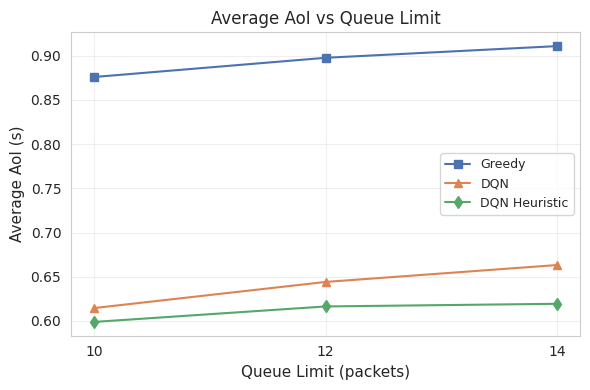

In [12]:
# Plot 1: Queue Analysis - AOI Mean
fig, ax = plt.subplots()
for i, method in enumerate(methods):
    ax.plot(data['queue_analysis']['x_values'], 
            data['queue_analysis']['aoi_mean'][method],
            label=method_labels[i], 
            marker=markers[i],
            color=colors[i])
ax.set_xlabel('Queue Limit (packets)')
ax.set_ylabel('Average AoI (s)')
ax.set_title('Average AoI vs Queue Limit')
ax.legend(loc='best', frameon=True)
ax.grid(True, alpha=0.3)
ax.set_xticks(data['queue_analysis']['x_values'])
plt.tight_layout()
plt.savefig('figures/queue_aoi.pdf', dpi=300, bbox_inches='tight')
# plt.savefig('queue_aoi_mean.png', dpi=300, bbox_inches='tight')
plt.show()

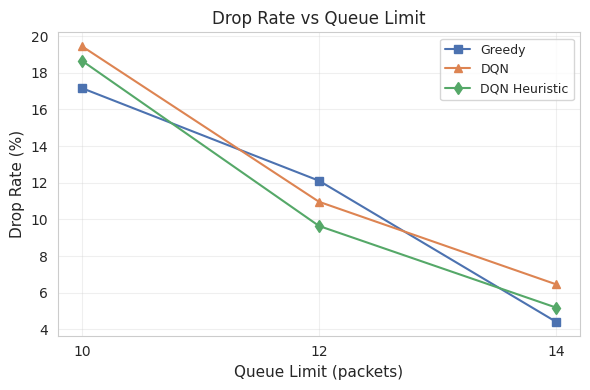

In [13]:
# Plot 2: Queue Analysis - Drop Mean
fig, ax = plt.subplots()
for i, method in enumerate(methods):
    ax.plot(data['queue_analysis']['x_values'], 
            data['queue_analysis']['drop_mean'][method],
            label=method_labels[i], 
            marker=markers[i],
            color=colors[i])
ax.set_xlabel('Queue Limit (packets)')
ax.set_ylabel('Drop Rate (%)')
ax.set_title('Drop Rate vs Queue Limit')
ax.legend(loc='best', frameon=True)
ax.grid(True, alpha=0.3)
ax.set_xticks(data['queue_analysis']['x_values'])
plt.tight_layout()
plt.savefig('figures/queue_drop_mean.pdf', dpi=300, bbox_inches='tight')
# plt.savefig('figures/queue_drop_mean.png', dpi=300, bbox_inches='tight')
plt.show()

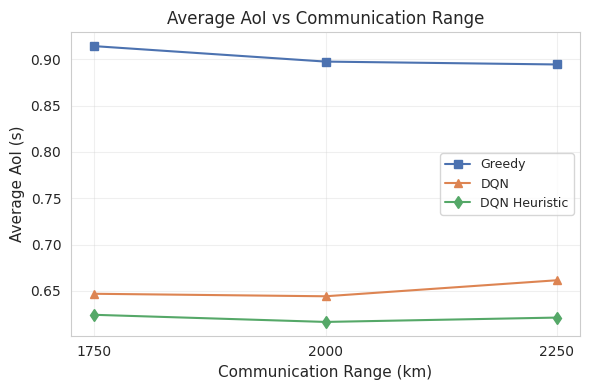

In [14]:
# Plot 3: Dmax Analysis - AOI Mean
fig, ax = plt.subplots()
for i, method in enumerate(methods):
    ax.plot(data['dmax_analysis']['x_values'], 
            data['dmax_analysis']['aoi_mean'][method],
            label=method_labels[i], 
            marker=markers[i],
            color=colors[i])
ax.set_xlabel('Communication Range (km)')
ax.set_ylabel('Average AoI (s)')
ax.set_title('Average AoI vs Communication Range')
ax.legend(loc='best', frameon=True)
ax.grid(True, alpha=0.3)
ax.set_xticks(data['dmax_analysis']['x_values'])
plt.tight_layout()
plt.savefig('figures/dmax_aoi_mean.pdf', dpi=300, bbox_inches='tight')
# plt.savefig('figures/dmax_aoi_mean.png', dpi=300, bbox_inches='tight')
plt.show()

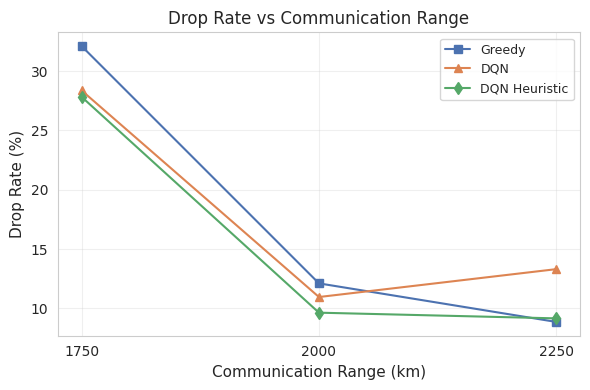

In [15]:
# Plot 4: Dmax Analysis - Drop Mean
fig, ax = plt.subplots()
for i, method in enumerate(methods):
    ax.plot(data['dmax_analysis']['x_values'], 
            data['dmax_analysis']['drop_mean'][method],
            label=method_labels[i], 
            marker=markers[i],
            color=colors[i])
ax.set_xlabel('Communication Range (km)')
ax.set_ylabel('Drop Rate (%)')
ax.set_title('Drop Rate vs Communication Range')
ax.legend(loc='best', frameon=True)
ax.grid(True, alpha=0.3)
ax.set_xticks(data['dmax_analysis']['x_values'])
plt.tight_layout()
plt.savefig('figures/dmax_drop_mean.pdf', dpi=300, bbox_inches='tight')
# plt.savefig('figures/dmax_drop_mean.png', dpi=300, bbox_inches='tight')
plt.show()